In [142]:
using Model
using Dictionaries, SplitApplyCombine
using DataFramesMeta, Dates
using CairoMakie, AlgebraOfGraphics
using StatsBase

In [143]:
using JSON3

dir = "../../data/processed/json_augmented"

json = mapreduce(vcat, joinpath.(dir, readdir(dir))) do file
    JSON3.read(read(file), jsonlines=true)
end

coverage = map(2000:2021) do y
    js = filter(json) do j
        Dates.year(Date(j["date"])) == y
    end

    filtered_outcome = count(j -> j.outcome != "other", js)
    #filtered_date = count(j -> Date(2000) <= Date(j.date) <= Date(2021), js)
    filtered_judges = count(j -> length(j.judges) == 5, js)
    filtered_patent = count(j -> !isnothing(j.patent.cpc), js)
    filtered_total = count(js) do j
        j.outcome != "other" &&
        #Date(2000) <= Date(j.date) <= Date(2021) &&
        length(j.judges) == 5 &&
        !isnothing(j.patent.cpc) &&
        length(filter(!isnothing, j.patent.cpc)) > 0
    end

    share(x) = round(x / length(js); digits=2)

    (;  year=y, 
        total=length(js),
        filtered_outcome=filtered_outcome |> share, 
        #filtered_date, 
        filtered_judges=filtered_judges |> share, 
        filtered_patent=filtered_patent |> share, 
        filtered_total=filtered_total |> share, 
    )
end

22-element Vector{NamedTuple{(:year, :total, :filtered_outcome, :filtered_judges, :filtered_patent, :filtered_total), Tuple{Int64, Int64, Float64, Float64, Float64, Float64}}}:
 (year = 2000, total = 72, filtered_outcome = 0.93, filtered_judges = 1.0, filtered_patent = 0.94, filtered_total = 0.92)
 (year = 2001, total = 79, filtered_outcome = 0.87, filtered_judges = 1.0, filtered_patent = 0.87, filtered_total = 0.86)
 (year = 2002, total = 79, filtered_outcome = 0.92, filtered_judges = 1.0, filtered_patent = 0.86, filtered_total = 0.86)
 (year = 2003, total = 76, filtered_outcome = 0.91, filtered_judges = 1.0, filtered_patent = 0.91, filtered_total = 0.91)
 (year = 2004, total = 82, filtered_outcome = 0.88, filtered_judges = 0.99, filtered_patent = 0.85, filtered_total = 0.84)
 (year = 2005, total = 85, filtered_outcome = 0.79, filtered_judges = 1.0, filtered_patent = 0.8, filtered_total = 0.79)
 (year = 2006, total = 78, filtered_outcome = 0.81, filtered_judges = 0.0, filtered_patent 

In [144]:
sum(c.total * c.filtered_total for c in coverage if c.year < 2021)

1227.2999999999997

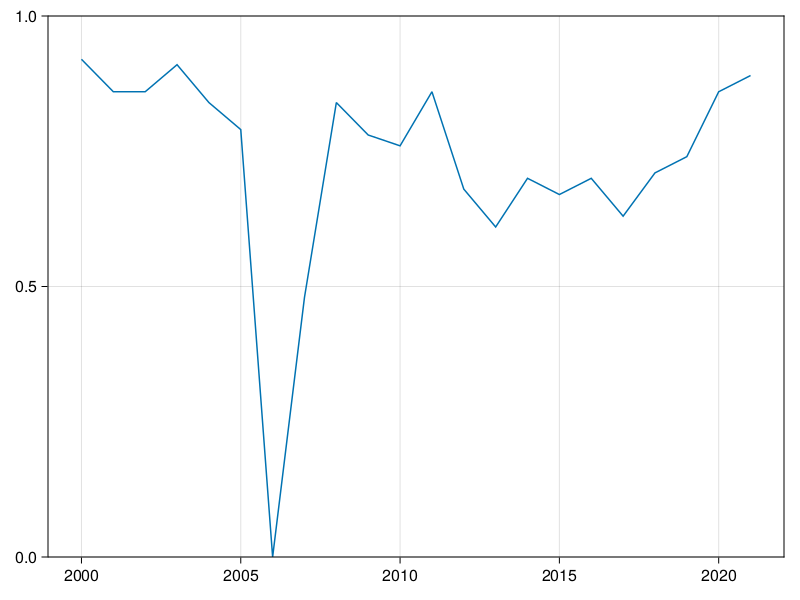

In [130]:
let x = [c.year for c in coverage], y = [c.filtered_total for c in coverage]
    lines(x, y); ylims!(0, 1); current_figure()
end

In [4]:
decisions = Model.loaddata("../../data/processed/json_augmented");

In [101]:
count(decisions) do d
    Dates.year(date(d)) == 2013
end

53

In [5]:
Model.label(s::String) = s

function flatten_and_summarize(decisions, by)
    df = DataFrame(group=by.(decisions), outcome=label.(outcome.(decisions)))
    df = @chain df begin
        DataFrames.flatten(:group)
        groupby([:group, :outcome])
        combine(nrow => :count)
        groupby(:group)
        @transform(:n = sum(:count))
        @rtransform(:share = :count / :n)
        unstack([:group, :n], :outcome, :share)
        @rtransform(:group = label(:group))
        sort!(:n; rev=true)
    end
end;

# Variation over time and by senate/board

In [46]:
map(group(label ∘ outcome, decisions)) do ds
    (;count=length(ds), share=round(length(ds) / length(decisions); digits=2))
end

3-element Dictionary{String, NamedTuple{(:count, :share), _A} where _A<:Tuple{Int64, Any}}
 "partially annulled" │ (count = 696, share = 0.57)
    "claim dismissed" │ (count = 295, share = 0.24)
           "annulled" │ (count = 236, share = 0.19)

In [132]:
let df = DataFrame(year=Dates.year.(date.(decisions)), outcome=(label ∘ outcome).(decisions))
    df = combine(groupby(df, [:year, :outcome]), nrow => :count)
    @rsubset df :year == 2007
end

Row,year,outcome,count
,Int64,String,Int64
1,2007,claim dismissed,14
2,2007,partially annulled,25
3,2007,annulled,2


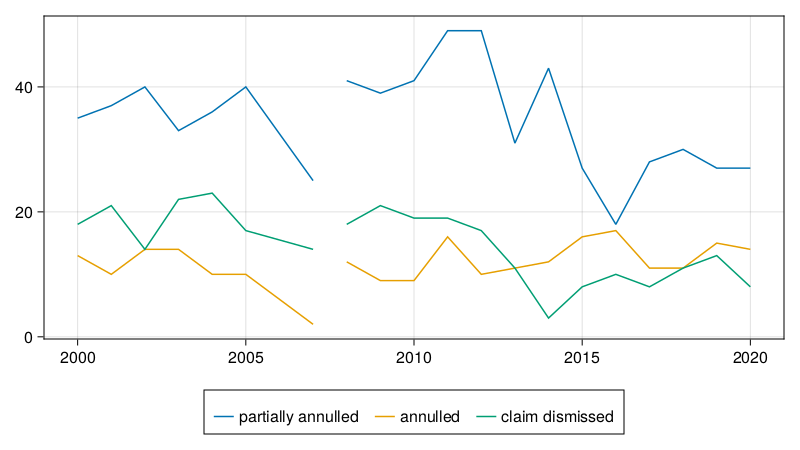

In [141]:
let df = DataFrame(year=Dates.year.(date.(decisions)), outcome=(label ∘ outcome).(decisions))
    df = combine(groupby(df, [:year, :outcome]), nrow => :count)
    
    order = ["partially annulled", "annulled", "claim dismissed"]
    append!(df, DataFrame(year=fill(2007, 3), outcome=order, count=fill(NaN, 3)); promote=true)
    sort!(df, :year)

    plt = data(df) * mapping(:year=>"", :count=>"", color=:outcome=>sorter(order)=>"") * visual(Lines)
    draw(plt; legend=(;position=:bottom), figure=(;resolution=(800, 450)))
end

In [86]:
decisions_from_board(decisions, board) = filter(d -> id(senate(d)) == board, decisions)
function plot_dates!(ax, ds; kwargs...)
    x = datetime2rata.(ds)
    xticks=(datetime2rata.(Date.(2000:5:2020)), string.(2000:5:2020))
    vlines!(ax, x; color=(:black, :0.8), kwargs...)
    ax.xticks = xticks
    hideydecorations!(ax)
    return
end
function plot_boards(decisions; boards=0:7, plotchanges=false, num_judges=5)
    fig = Figure(resolution=(800, 400))
    for (i, board) in enumerate(boards)
        Label(fig[i, 1], "Board $board")
        ax = Axis(fig[i, 2]; xgridvisible=false)
        ds = decisions_from_board(decisions, board)
        plot_dates!(ax, date.(ds))
        xlims!(ax, datetime2rata.((Date(1999), Date(2022))))
        i != length(boards) && hidexdecorations!(ax)
    end
    resize_to_layout!(fig)
    fig
end

plot_boards (generic function with 1 method)

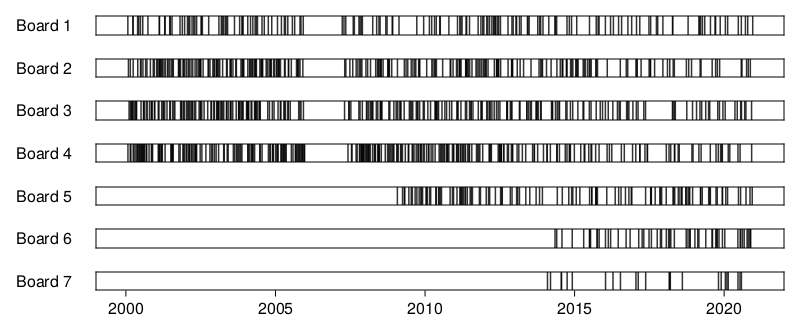

In [87]:
plot_boards(decisions; boards=1:7)

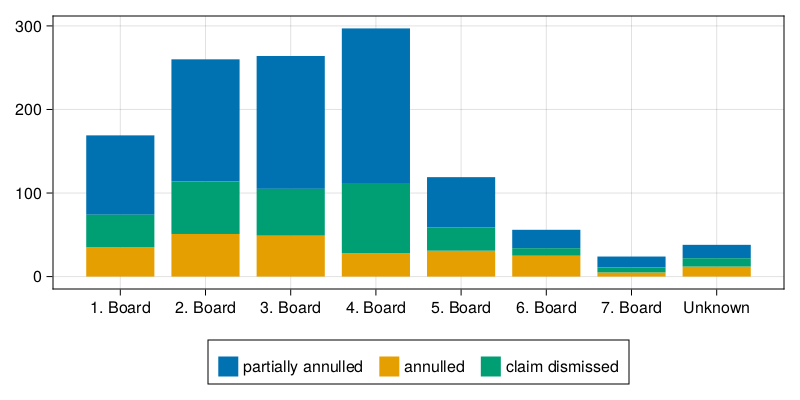

In [145]:
let df = DataFrame(senate=(label ∘ senate).(decisions), outcome=(label ∘ outcome).(decisions))
    df = combine(groupby(df, [:senate, :outcome]), nrow => :count)
    df.senate = replace.(df.senate, "0. Senate" => "Unknown")
    df.senate = replace.(df.senate, r"Senate" => "Board")

    order = ["partially annulled", "annulled", "claim dismissed"]
    plt = data(df) * mapping(:senate=>"", :count=>"", color=:outcome=>sorter(order)=>"", stack=:outcome) * visual(BarPlot)
    draw(plt; legend=(;position=:bottom), figure=(;resolution=(800, 400)))
end

# Variation by judges and CPC classes

In [61]:
function plot_outcome_judge(df; title="", subtitle="")
    outcomes = ["claim dismissed" => "dismissed", 
                "partially annulled" => "partially annulled", 
                "annulled" => "annulled"]

    dftop = first(rename(df, outcomes), 30)
    dflong = DataFrames.stack(dftop, last.(outcomes))
    dflong.counts = dflong.value .* dflong.n

    judgeorder = sort!(dftop, :dismissed).group
    N = length(judgeorder)

    fig = Figure(resolution=(800, 450))

    pl1 = data(unique(dflong, [:group, :n])) * mapping(
            :group => sorter(judgeorder) => "", :n => "";
          ) * visual(BarPlot)

    axis = (;xticklabelsvisible=false, xgridvisible=false, 
            title, subtitle, titlealign=:left, titlesize=20, subtitlecolor=:grey50)

    gr1 = draw!(fig[1,1], pl1; axis)
    xlims!(0.2, length(judgeorder) + 0.8)

    order = ["partially annulled", "annulled", "dismissed"]

    pl2 = data(dflong) * mapping(
            :group => sorter(judgeorder) => "", :value => ""; 
            stack=:variable,# => sorter(order) => "", 
            color=:variable => sorter(order) => ""
          ) * visual(BarPlot)

    ax2 = axis=(;xticks=(1:N, string.(1:N)), xticklabelsize=10, xgridvisible=false)
      
    gr2 = draw!(fig[2,1], pl2;  axis=ax2)
    xlims!(0.2, length(judgeorder) + 0.8); ylims!(-0.01, 1.01)
    #legend!(fig[3,1], gr2; tellwidth=false, tellheight=true, orientation=:horizontal)

    rowsize!(fig.layout, 1, Relative(.4))
    
    fig
end;

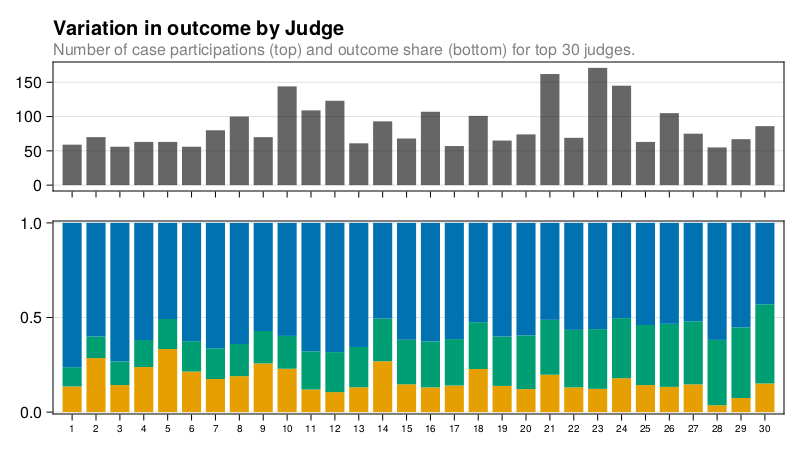

In [62]:
let df = flatten_and_summarize(decisions, judges)
    title = "Variation in outcome by Judge"
    subtitle = "Number of case participations (top) and outcome share (bottom) for top 30 judges."
    fig = plot_outcome_judge(df; title, subtitle)
    save("variation_judges.png", fig; px_per_unit=2)
    fig
end

In [153]:
using DataFramesMeta

let df = flatten_and_summarize(decisions, judges)
    @rsubset! df :n >= 50
    extrema(df.var"claim dismissed")
end

(0.1016949152542373, 0.46153846153846156)

In [59]:
function plot_outcome_tech(df; title="", subtitle="")
    outcomes = ["claim dismissed" => "dismissed", 
                "partially annulled" => "partially annulled", 
                "annulled" => "annulled"]

    dftop = first(rename(@rsubset(df, :group != "Y10"), outcomes), 30)
    dflong = DataFrames.stack(dftop, last.(outcomes))
    dflong.counts = dflong.value .* dflong.n

    order = sort!(dftop, :dismissed).group
    N = length(order)

    fig = Figure(resolution=(800, 450))

    pl1 = data(unique(dflong, [:group, :n])) * mapping(
            :group => sorter(order) => "", :n => "";
          ) * visual(BarPlot)

    axis = (;xticklabelsvisible=false, xgridvisible=false, 
            title, subtitle, titlealign=:left, titlesize=20, subtitlecolor=:grey50)

    gr1 = draw!(fig[1,1], pl1; axis)
    xlims!(0.2, N + 0.8)

    order_outcome = ["partially annulled", "annulled", "dismissed"]

    pl2 = data(dflong) * mapping(
            :group => sorter(order) => "", :value => ""; 
            stack=:variable ,# => sorter(reverse(order_outcome)) => "", 
            color=:variable => sorter(order_outcome) => ""
          ) * visual(BarPlot)

    ax2 = axis=(;xticklabelsize=10, xgridvisible=false)
      
    gr2 = draw!(fig[2,1], pl2;  axis=ax2)
    xlims!(0.2, N + 0.8); #ylims!(-0.01, 1.01)
    legend!(fig[3,1], gr2; tellwidth=false, tellheight=true, orientation=:horizontal)

    rowsize!(fig.layout, 1, Relative(.3))
    
    fig
end;

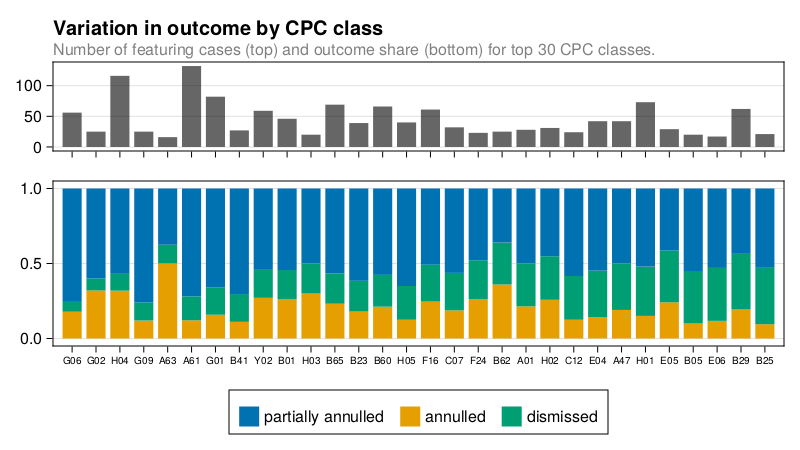

In [60]:
let df = flatten_and_summarize(decisions, class ∘ patent)
    title = "Variation in outcome by CPC class" 
    subtitle = "Number of featuring cases (top) and outcome share (bottom) for top 30 CPC classes."
    fig = plot_outcome_tech(df; title, subtitle)
    save("variation_tech.png", fig; px_per_unit=2)
    fig
end